# Análise Exploratória dos Dados (EDA)

### 1. Introdução ao RAVDESS Dataframe

#### Aqui está um exemplo de um nome de arquivo de áudio conforme descrito no site oficial do RAVDESS:
    - Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
    - Vocal channel (01 = speech, 02 = song).
    - Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
    - Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
    - Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
    - Repetition (01 = 1st repetition, 02 = 2nd repetition).
    - Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

#### Aqui está um exemplo do aúdio 02-01-06-01-02-01-12.mp4. Isso significa que os metadados para esse arquivo de áudio são:
    - Video-only (02)
    - Speech (01)
    - Fearful (06)
    - Normal intensity (01)
    - Statement "dogs" (02)
    - 1st Repetition (01)
    - 12th Actor (12) - Female (as the actor ID number is even)

### 2. Criando um DataFrame sobre os arquivos de áudio do dataset RAVDESS

#### 2.1. Importando as bibliotecas

In [61]:
import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

#### 2.2. Criando o dataframe

In [95]:
# em windows, é necessário que seja uma r-strings, pois '\' é um caractere de escape!

Ravdess = "C:/Users/Vinícius/Desktop/miniprojeto Trilha/miniprojeto2/raw" # Diretório onde estão salvos os áudios originais

## Significado de cada função:  
  
**listdir()**: retorna uma lista com os nomes dos arquivos ou pastas de um diretório específico  

**file.slipt('.')**: divide a string em duas: a parte que contém as informações e a extensão do arquivo  

**DataFrame()**: transforma um objeto iterável em um DataSet. Podemos definir as colunas

**.replace()**: altera os valores de uma coluna de um DataSet.  
**Diferença entre replace() e map()**: no map, os valores que não estão no dicionário são transformados em nulo. No replace, isso não acontece

## Objetivo do código:  
  
Cada pasta contém os áudios de 1 ator, que gravou vários áudios  
  
**1° Este código vai iterar sobre cada pasta, e dentro de cada uma, ele vai iterar sobre cada áudio  
2° Em cada áudio, ele vai guardar no índice i a emoção e o diretório de cada áudio**  
  
Ao final, tudo isto estará armazenado em duas listas:  

**uma será para guardar a emoção do audio de indice i**  
**outra será para armazenar o caminho do áudio de índice i**  

A ideia é transformar cada lista em um dataset, e ,após transformar, irá concatenar os dois datasets

In [96]:
# itera sobre cada pasta que contem os dados de cada ator e armazena em ums lista
ravdess_directory_list = os.listdir(Ravdess) 

file_emotion = []
file_path = []
for dir in ravdess_directory_list: #itera em cada ator

    # dir é o nome de cada pasta -> Ravdess + dir é o arquivo de áudio de cada ator  
    # é necessário adicionar '/', para que a string que representa a barra seja entendida pelo Windows
    actor = os.listdir(Ravdess + '/' + dir) 

    #itera em cada audio feio pelos atores
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')

        file_emotion.append(int(part[2])) # o indice 2 representa a emoção do audio 
        file_path.append(Ravdess + '/' + dir + '/' + file) # salvamos o diretório do arquivo que analisamos a emoção

# Transformamos as emoções e os caminhos em dataframes separados:        
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])

# concatenando os dataframes pela coluna. Se axis == 0, então adiciona nas linhas
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# mudando os valores inteiros para as emoções que cada um representa
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

,Emotions,Path
0,neutral,C:/Users/Vinícius/Desktop/miniprojeto Trilha/m...
1,neutral,C:/Users/Vinícius/Desktop/miniprojeto Trilha/m...
2,neutral,C:/Users/Vinícius/Desktop/miniprojeto Trilha/m...
3,neutral,C:/Users/Vinícius/Desktop/miniprojeto Trilha/m...
4,calm,C:/Users/Vinícius/Desktop/miniprojeto Trilha/m...


### 3. Limpeza dos Dados
- Agora que criamos o nosso Dataframe, precisamos nos certificar que ele está limpo de erros e pronto para os próximos passos.

#### 3.1. Verificando se há arquivos corrompidos, muito curtos ou com problemas de leitura

## Funções usadas: 
### **.load**: esta função carrega o arquivos de áudio. Dois retornos:  
  
1° array numpy que contém números sobre os valores do áudio no gráfico  
2° sample rate: taxa de amostragem de áudio. Quanto maior, mais contínuo é um áudio, ou seja, mais frequências o computador consegue capturar  

### **.get_duration**: serve para descobrir o tempo da musica.  
         
**como descobrir a duração**: cada audio tem um array numpy associado e seu sample rate, que é a quantidade de valores que tomamos por segundo. Assim, podemos descobrir o tempo do audio com **len(audio) / sr**  
  
### **.isin()**: serve para descobrir se um valor em um dataset está presente em um iterável
  

In [97]:
def check_audio_files(df):
    audios = df['Path'].unique()
    valid_files = []
    invalid_files = []

    for path in audios:
        try:
            audio, sr = librosa.load(path, sr=44100)
        except:
            invalid_files.append(path)
        else:
            duration = len(audio) / sr # calcula duração de acordo com o sample rate

            if (duration < 1.0):
                invalid_files.append(path)
            else:
                valid_files.append(path)

    return valid_files, invalid_files

# Verificar os arquivos do dataset
valid_files, invalid_files = check_audio_files(Ravdess_df)

# Filtra o dataset para manter os arquivos que estão na lista valid_files
Ravdess_df = Ravdess_df[Ravdess_df["Path"].isin(valid_files)]

print(f"Arquivos válidos: {len(valid_files)}")
print(f"Arquivos inválidos/removidos: {len(invalid_files)}")

Arquivos válidos: 1012
Arquivos inválidos/removidos: 0


### 4. Exploração e Visualização dos Dados

#### 4.1. Visualizando quais são as principais emoções presentes em nosso dataframe

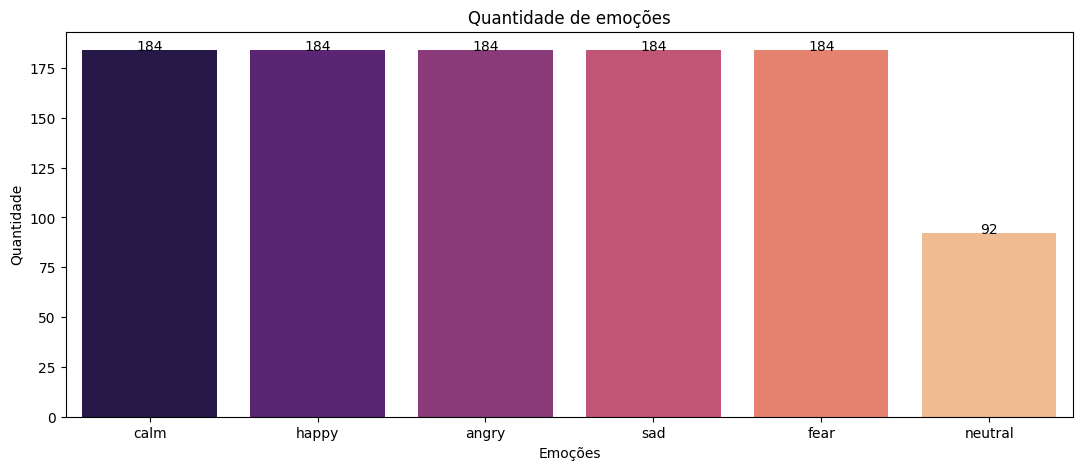

In [98]:
emotions = Ravdess_df['Emotions'].value_counts()

plt.figure(figsize=(13, 5)) # ajusta o tamanho total do gráfico

# pallete é a palete de core, width é a largura das barras
sns.barplot(x=emotions.index, y=emotions.values, palette="magma", width=0.8)

# escreve a quantidade de cada emoção em cima da barra
for i in range(0, len(emotions)):
    plt.text(i, emotions[i], emotions[i], ha = 'center')

plt.title("Quantidade de emoções")
plt.xlabel("Emoções")
plt.ylabel("Quantidade")

plt.show()


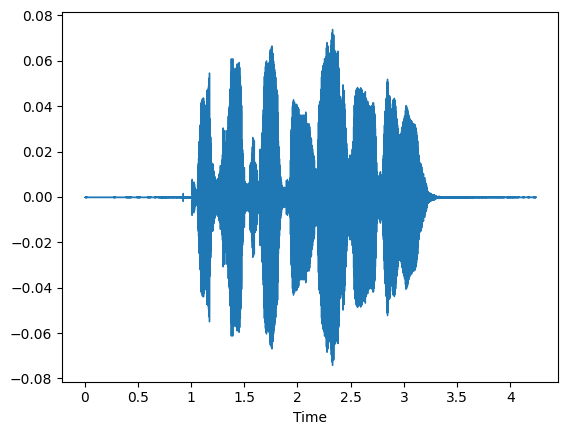

In [99]:
path = Ravdess_df['Path'][0]

audio, sr = librosa.load(path, sr=44100)

librosa.display.waveshow(y=audio, sr=sr)



#### 4.2. Plotando o sinal de aúdio em forma de onda e em espectograma
- Forma de Onda - Os Waveplots nos permitem visualizar a intensidade (volume) do áudio em um determinado momento.
- Espectrogramas - Um espectrograma é uma representação visual do espectro de frequências de um som ou de outros sinais à medida que variam ao longo do tempo. Ele mostra como as frequências mudam em relação ao tempo para um determinado sinal de áudio.

## Ondas sonoras: forma de representar o som 
  
Primeiramente, o som é **gerado por vibrações no ar**. Cada som possui um valor único de vibrações por segundo  
  
  A **frequência** é quantas vezes um som é vibrado por segundo. Sons mais agudos são vibrados muitas vezes por segundo. O ouvido
 humanos recebe essas vibrações por sensores no ouvido.  
 **Amplitude** é o volume que percebemos o som



Podemos representar essas vibrações por meio de gráficos em que:  

**eixo X**: tempo (em segundos)  
**eixo Y**: amplitude  

O intervalor entre cada segundo vibra muitas vezes. Assim, conseguimos medir a frequência

## Funções usadas:  
  
### **librosa.display.waveshow()**: plota o gráfico de ondas sonoras de um áudio  
Recebe um array numpy e seu sample rate associado.  

### **librosa.stft**: transforma um dado de amplitude e tempo em um dado com frequência sonora  
  
### **np.abs**: o valor retornado pelo stft é dado em números imaginários e essa função converte para números reais  

### **amplitude_to_db**: leva a amplitude para uma escala de dB (decibeis).  
  
**decibeis** é uma escala logaritmica que os seres humanos ouvem. Ao medir em logaritmicos, conseguimos ser mais precisos para determinar a amplitude de um som para um ser humano.  

  


## Transformada de Fourrier:  

É uma função matemática em que é possível descobrir a frequência de um áudio somente com sua amplitude durante o tempo

In [100]:
# data é o array numpy com os valores da onda sonora
# sr é o sample rate
# e é a emoção

def create_waveplot(data, sr, e):
    plt.figure(figsize=(15,5))
    plt.title(f"Waveplot for audio with {e}", fontsize=14)
    librosa.display.waveshow(y=data, sr=sr) #plota o gráfico

def create_spectrogram(data, sr, e):
    plt.figure(figsize=(15,5))

    D = librosa.amplitude_to_db(np.abs(librosa.stft(data)))
    librosa.display.specshow(D, x_axis='time', y_axis='linear', sr = sr, cmap='magma')

    plt.title(f"Waveplot for audio with {e}", fontsize=14)
    plt.xlabel('Time [s]')
    plt.ylabel('Frequency [Hz]')
    plt.colorbar(format='%+2.0f dB')

#### Agora rode as células abaixo para ver os resultados do que você fez :)

#### Emoção de Medo

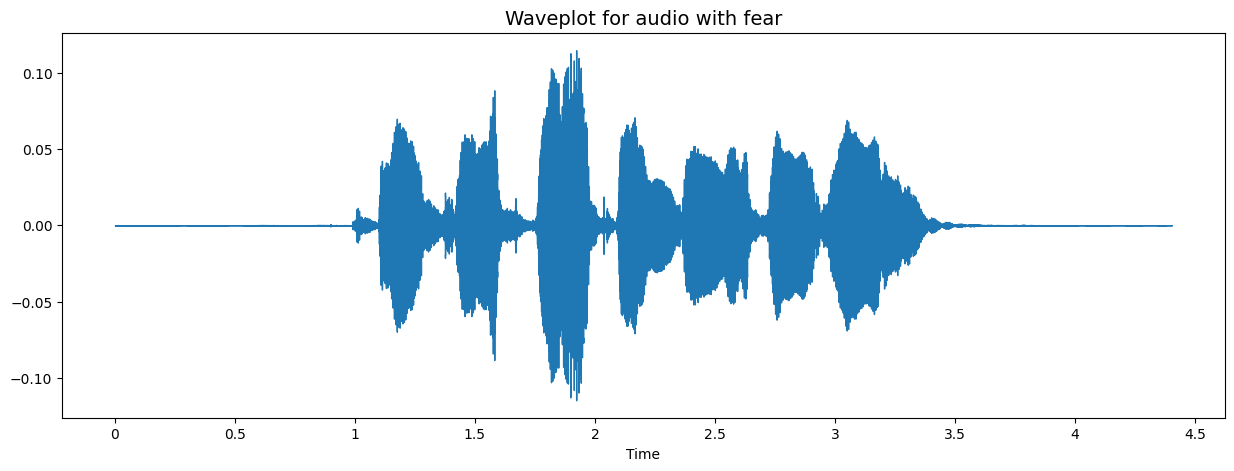

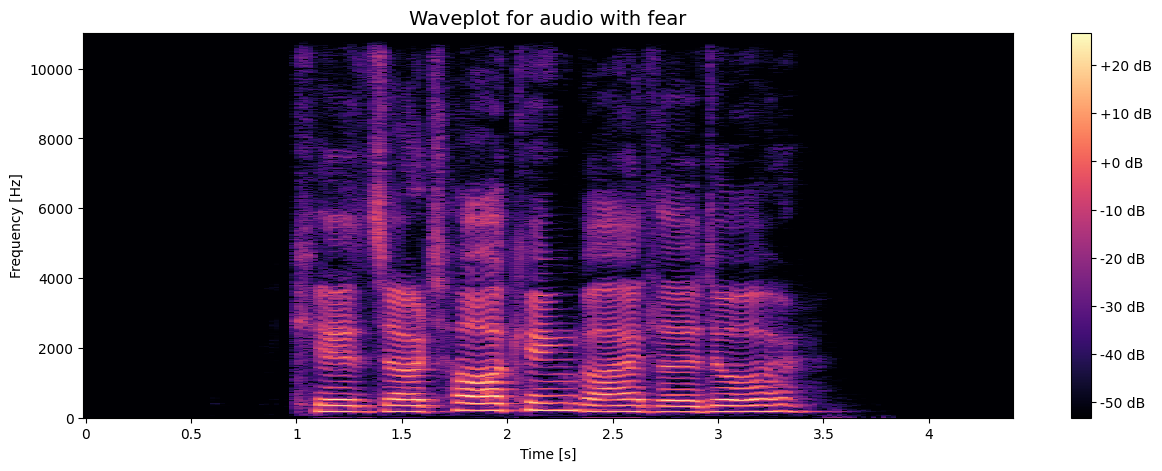

In [101]:
emotion='fear'
path = np.array(Ravdess_df.Path[Ravdess_df.Emotions==emotion])[0]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

#### Emoção de felicidade

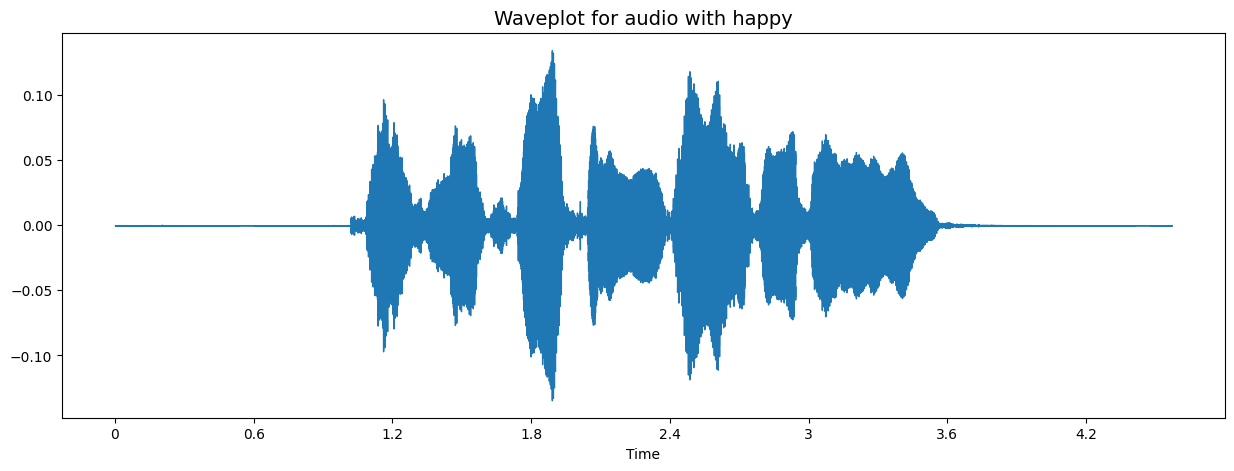

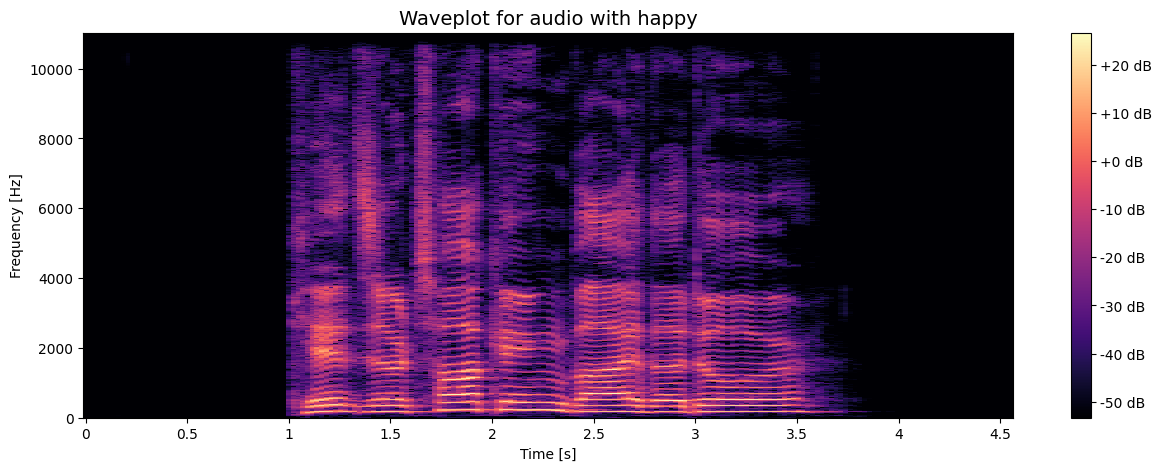

In [102]:
emotion='happy'
path = np.array(Ravdess_df.Path[Ravdess_df.Emotions==emotion])[0]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

#### 4.3. Analisar a duração dos áudios

**iterrows()** é uma função que permite iterar a cada linha do dataframe.  

Retorna **dois itens**: o índice da linha e um dicionário que contém os valores de cada coluna

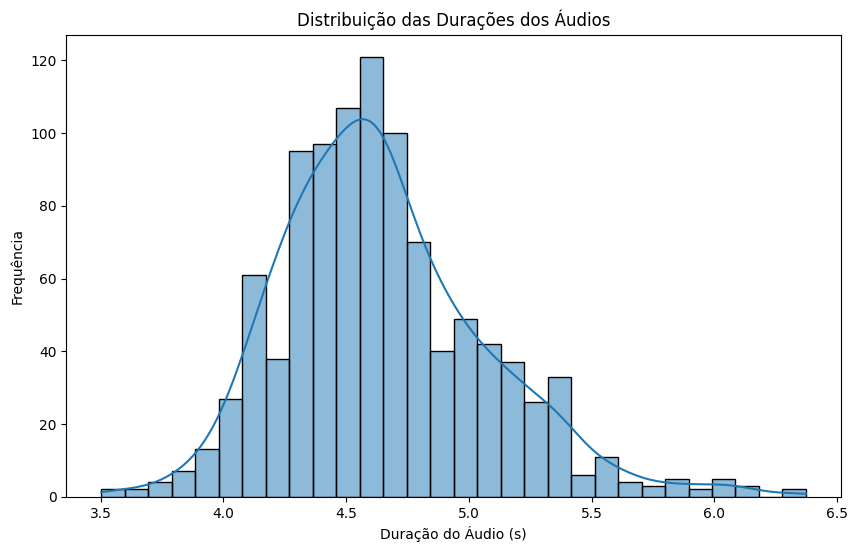

In [103]:
duration = []

# iterrows itera a cada linha em um dataframe e retorna um DICIONÁRIO em que as chaves são as colunas e valores são as linhas do dataframe
for index, path in Ravdess_df.iterrows():
    duration.append(librosa.get_duration(path= path.get('Path'), sr=44100))

plt.figure(figsize=(10, 6))
sns.histplot(data=duration, bins= 30, kde=True)

plt.title('Distribuição das Durações dos Áudios')
plt.xlabel('Duração do Áudio (s)')
plt.ylabel('Frequência')
plt.show()

### 5. Aumento de Dados (Data Augmentation)
- O aumento de dados é o processo pelo qual criamos novas amostras sintéticas de dados adicionando pequenas perturbações ao nosso conjunto de treinamento original.
- Para gerar dados sintéticos para áudio, podemos aplicar injeção de ruído, deslocamento no tempo, alteração de tom (pitch) e velocidade.
- O objetivo é tornar nosso modelo invariante a essas perturbações e melhorar sua capacidade de generalização.
- Para que isso funcione, as perturbações adicionadas devem manter o mesmo rótulo da amostra de treinamento original.
- No caso de imagens, o aumento de dados pode ser realizado por meio de deslocamento, zoom, rotação, entre outras técnicas.

Agora, vamos verificar quais técnicas de aumento de dados funcionam melhor para o nosso conjunto de dados :)

### **Ruído**:  
Ruído nada mais é do que **valores de amplitude ou frequência aleatórios**. Assim, geramos um vetor com números aleatórios que seguem uma distribuição normal, ou seja, a maioria dos valores estão perto da média.  

Esse vetor **terá uma média 0**, pois os valores estão entre -1 e 1, e o **desio padrão será igual ao do áudio**  

### **Stretch (alongamento)**: alonga ou diminui a velocidade de um áudio  

Se rate > 1.0, acelera. Se rate < 1.0, então diminui a velocidade  

### **Shift**: deslocar o array numpt usado para representar os valores de amplitude. Os valores são deslocados com um fator aleatório

### **pitch**: altera a frequência, ou seja, a oitava das notas. 



In [ ]:
def noise(data):
    # PARÂMETROS: (valor da média, valor do desvio padrão, quantos numeros devem ser gerados)
    n = np.random.normal(0, data.std(), data.size) # cria um vetor com numeros aleatorio com media 0 e desvio igual ao audio
    augmentation_data = data + n # adiciona ruido
    return augmentation_data

def stretch(data, rate=0.8):
    # Desacelera o áudio para 0.8 mais devagar
    return librosa.effects.time_stretch(y=data, rate=rate)

def shift(data):
    #escolha um número aleatório, que é a quantidade de vezes que deslocará um número deste array 
    data = np.roll(data, np.random.randint(1, len(data)))
    return data

def pitch(data, sampling_rate, pitch_factor=0.7):
    # Altera a altura (oitava) de acordo com um fator qualquer
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)


# Taking any example and checking for techniques.
path = np.array(Ravdess_df.Path)[1]
data, sample_rate = librosa.load(path)

#### 5.1. Simple Audio

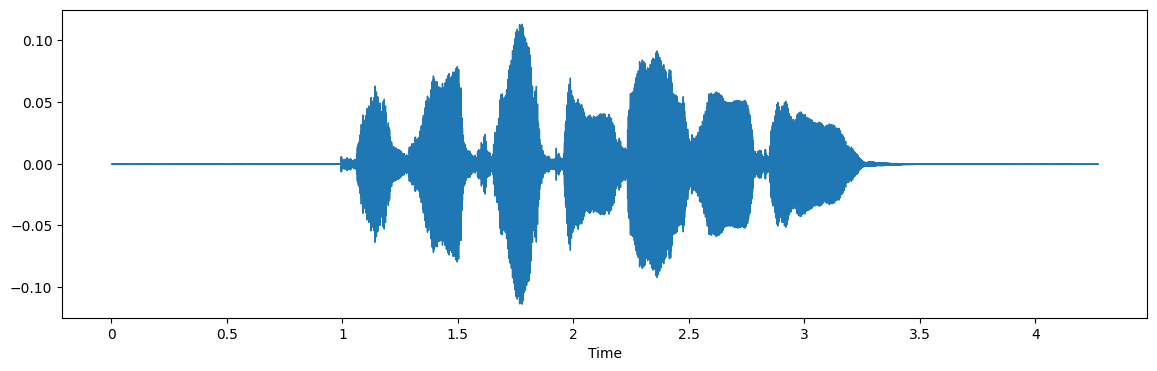

In [105]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

#### 5.2. Noise Injection (Injeção de ruído)

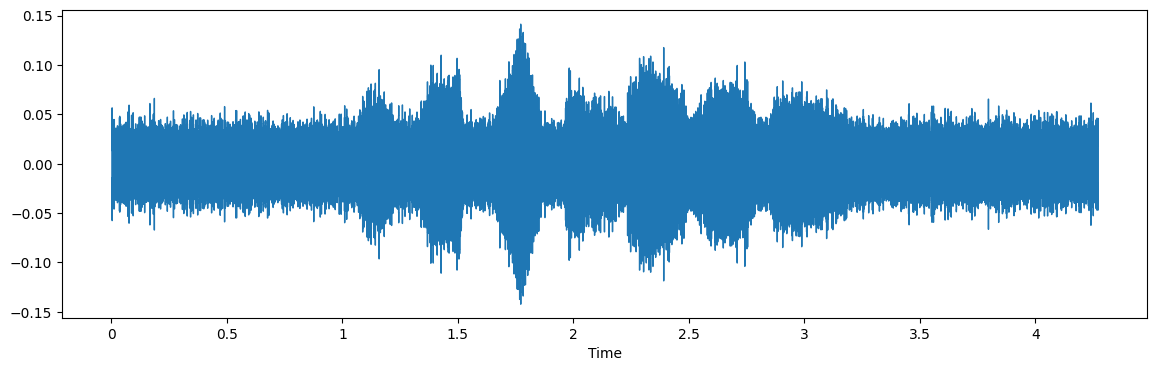

In [106]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 5.3. Stretching (Alongamento)
- Mudando a velocidade do aúdio

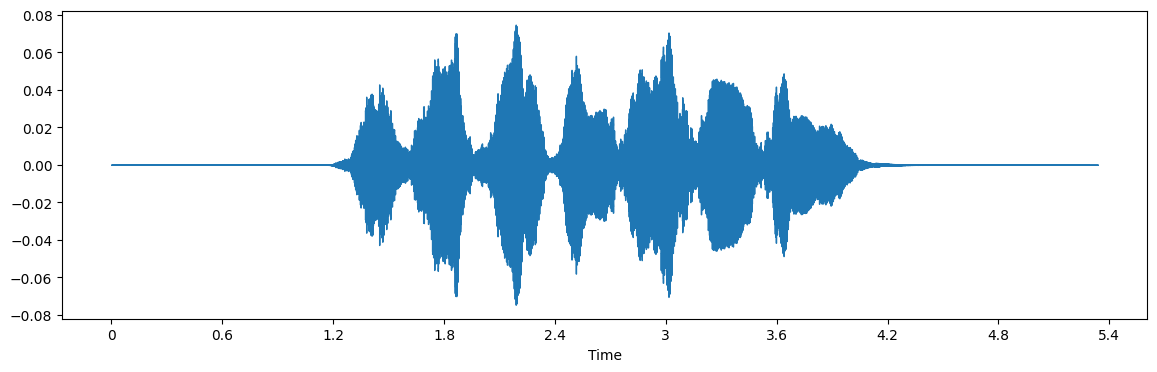

In [107]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 5.4. Shifting (Deslocamento)
- Estou deslocando o sinal de áudio no tempo

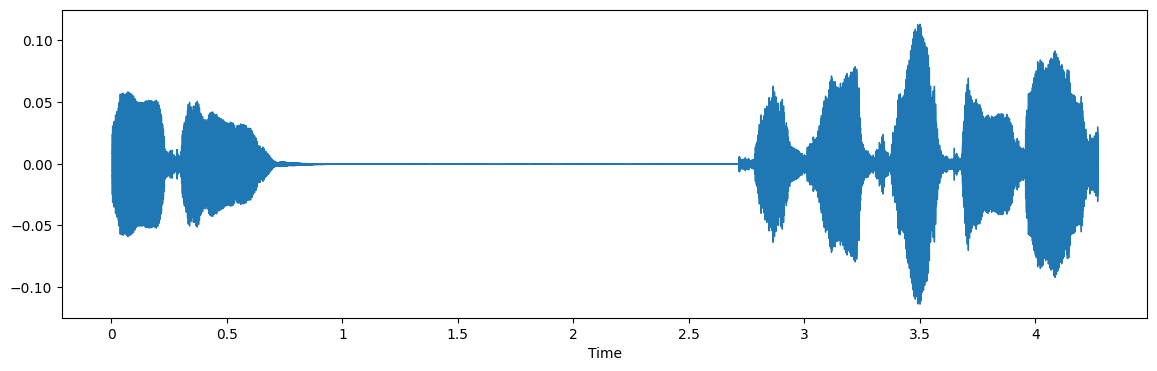

In [108]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 5.5. Pitch (Tom)

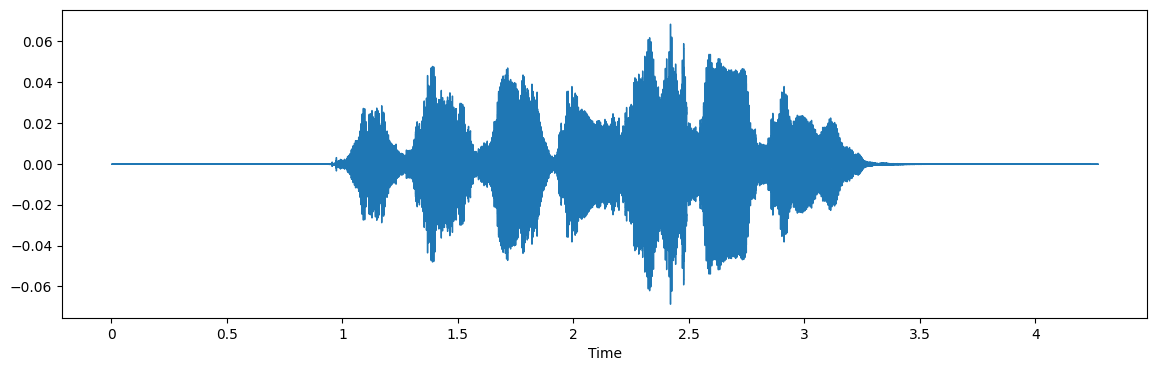

In [109]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

In [110]:
Ravdess_df.tail()

,Emotions,Path
1007,fear,C:/Users/Vinícius/Desktop/miniprojeto Trilha/m...
1008,fear,C:/Users/Vinícius/Desktop/miniprojeto Trilha/m...
1009,fear,C:/Users/Vinícius/Desktop/miniprojeto Trilha/m...
1010,fear,C:/Users/Vinícius/Desktop/miniprojeto Trilha/m...
1011,fear,C:/Users/Vinícius/Desktop/miniprojeto Trilha/m...


### 6. Preparando o dataframe para a extração das features

#### 6.1. Função para Padronizar Áudios

In [111]:
import soundfile as sf 

def preprocess_and_save_audio(input_path, output_dir, target_sr=16000):
    """
    Padroniza e salva os arquivos de áudio.
    
    Args:
    - input_path (str): Caminho do arquivo de entrada.
    - output_dir (str): Diretório para salvar o arquivo processado.
    - target_sr (int): Taxa de amostragem desejada (default: 16000).
    
    Retorna:
    - str: Caminho do arquivo processado.
    """
    os.makedirs(output_dir, exist_ok=True) # exist_ok significa que se o diretório já existe, então ignore essa linha
    try:
        # Carregue o áudio com librosa.load e converta para mono
        y, sr = librosa.load(input_path, sr=44100)

        # converte o audio para mono
        audio = librosa.to_mono(y)

        #salva o arquivo com o mesmo nome que ele tinha no raw
        output_path = output_dir + '/' + input_path.split('/')[-1]

        # Salvar o áudio processado
        sf.write(output_path, audio, target_sr)
        return output_path
    except Exception as e:
        print(f"Erro ao processar {input_path}: {e}")
        return None

#### 6.2. Aplicar a Padronização a Todos os Áudios

## Funções para manipular arquivos:  

### **makedirs()**: cria pastas  
- **Parâmetros**: ("caminho com o nome da pasta", exist_ok=True)

Exist_ok: se o diretório já existir, então não imprime erro na tela



### **to_csv**: função que salva um dataset em um arquivos .csv  
- **Parâmetros**: ("caminho do diretório", index=False)  
- Index é falso porque se nao, o pandas tenta indexar a coluna

In [112]:
# .dirname() retorna o diretório pai 
# .getcwd() retorna o diretório atual
# .join() junta todas as strings passada como parâmetro

processed_audio_dir = os.path.join(os.path.dirname(os.getcwd()), "data", "processed_audio")

# Criar o diretório se não existir
os.makedirs(processed_audio_dir, exist_ok=True)

print(f"Os arquivos serão salvos em: {processed_audio_dir}")

# itera em cada path presente no dataset
Ravdess_df["Processed_Path"] = Ravdess_df["Path"].apply(
    lambda x: preprocess_and_save_audio(x, processed_audio_dir) # x é um caminho para um arquivo
)
# os arquivos que falharam são processados como None (NULO) no dataset

# Remover arquivos que falharam no processamento
Ravdess_df = Ravdess_df[Ravdess_df["Processed_Path"].notnull()]

Os arquivos serão salvos em: c:\Users\Vinícius\Desktop\miniprojeto Trilha\miniprojeto2\data\processed_audio


#### 6.3. Salvar o DataFrame Final

In [113]:
data_dir = os.path.join(os.path.dirname(os.getcwd()), "data")
os.makedirs(data_dir, exist_ok=True) # cria um pasta data

# junta a string data_dir com a string do nome do csv
csv_path = os.path.join(data_dir, "ravdess_preprocessed.csv")

# Salva o dataset no arquivo csv que estava vazio
Ravdess_df.to_csv(csv_path, index=False)

print(f"O arquivo foi salvo em: {csv_path}")

O arquivo foi salvo em: c:\Users\Vinícius\Desktop\miniprojeto Trilha\miniprojeto2\data\ravdess_preprocessed.csv


### Isso é tudo por aqui, você fez um ótimo trabalho e está indo muito bem!
#### Estamos prontos para o pŕoximo notebook, mas antes vamos ver as coisas que aprendemos até então:
- Criamos o dataframe (você mudou o path e entendeu a cara do nosso dataframe)
- Limpamos os dados (verificamos se existiam aúdios corrompidos)
- Plotamos gráficos (fizemos uns gráficos bem bonitos sobre o dataframe)
- Data augmentation (aplicamos algumas funções no aúdio para aumentar a quantidade de dados)
- Salvamos um dataframe com pandas (usamos to_csv)